In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
from gempyor import config, model_info, outcomes, seir

import os

# disable  operations using the MKL linear algebra.
os.environ["OMP_NUM_THREADS"] = "1"


data_dir = "RSV_USA/"
import os
os.chdir(data_dir)
data_dir = "."  # necessary for now for time serie parameters !!! fixme 

In [2]:
config_path = f"config_MN_ageihrs_diffseas.yml"
run_id = "config_MN_ageihrs_diffseas.yml"

config.clear()
config.read(user=False)
config.set_file(config_path)
print(config_path)


seir_modifiers_scenario="none"
outcome_modifiers_scenario="IHRadj"

in_run_id = run_id
out_run_id = in_run_id
in_prefix = "emcee"

out_prefix = in_prefix

write_csv = False
write_parquet = True
modinf = model_info.ModelInfo(
    config=config,
    nslots=1,
    seir_modifiers_scenario=seir_modifiers_scenario,
    outcome_modifiers_scenario=outcome_modifiers_scenario,
    write_csv=write_csv,
    write_parquet=write_parquet,
    first_sim_index=1,
    in_run_id=in_run_id,
    in_prefix=in_prefix,
    inference_filename_prefix="no",
    inference_filepath_suffix="no",
    out_run_id=out_run_id,
    out_prefix=out_prefix,
    stoch_traj_flag=False,
)

CRITICAL:root:No mobility matrix specified -- assuming no one moves


config_MN_ageihrs_diffseas.yml


In [3]:
# find what to perturb
fitted_params = {
    "ptype":[],
    "pname":[],
    "pdist":[],
    "ub":[],
    "lb":[],
}
ndim=0

print("SEIR MODIFIERS")
for npi in gempyor.config["seir_modifiers"]["modifiers"].get():
    if gempyor.config["seir_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["seir_modifiers"]["modifiers"][npi]
        fitted_params["ptype"].append("snpi")
        fitted_params["pname"].append(npi)
        fitted_params["pdist"].append(c["value"].as_random_distribution())
        fitted_params["lb"].append(c["value"]["a"].get())
        fitted_params["ub"].append(c["value"]["b"].get())
        print(f" >> {npi} has perturbation, recording")
        ndim+=len(modinf.subpop_struct.subpop_names)
        
print("OUTCOMES MODIFIERS")   
for npi in gempyor.config["outcome_modifiers"]["modifiers"].get():
    if gempyor.config["outcome_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["outcome_modifiers"]["modifiers"][npi]
        fitted_params["ptype"].append("hnpi")
        fitted_params["pname"].append(npi)
        fitted_params["pdist"].append(c["value"].as_random_distribution())
        fitted_params["lb"].append(c["value"]["a"].get())
        fitted_params["ub"].append(c["value"]["b"].get())
        print(f" >> {npi} has perturbation, recording")
        ndim+=len(modinf.subpop_struct.subpop_names)

SEIR MODIFIERS
 >> Ro_mod has perturbation, recording
 >> covid_mod has perturbation, recording
 >> omicron_mod has perturbation, recording
 >> seas_amp_mod has perturbation, recording
 >> seas_offset_mod has perturbation, recording
OUTCOMES MODIFIERS
 >> IHRadj_age0to11m has perturbation, recording
 >> IHRadj_age1to4 has perturbation, recording
 >> IHRadj_age5to17 has perturbation, recording
 >> IHRadj_age18to49 has perturbation, recording
 >> IHRadj_age50to64 has perturbation, recording
 >> IHRadj_age65to100 has perturbation, recording


In [4]:
# Find the ground-truth
gt = pd.read_csv(f"{data_dir}/"+gempyor.config["inference"]["gt_data_path"].get())
# gt
statistics = {}
# # Ingoring agreegation and all, assuming by weekP
for stat in gempyor.config["inference"]["statistics"]:
    statistics[gempyor.config["inference"]["statistics"][stat]["sim_var"].get()] = gempyor.config["inference"]["statistics"][stat]["data_var"].get()
statistics
gt = gempyor.read_df(gempyor.config["inference"]["gt_data_path"].get())
gt["date"]= pd.to_datetime(gt['date'])
gt = gt.set_index("date")

## Create the first gempyor object

In [5]:

print("MAKING A TEST RUN TO GET SETUP")
(
    unique_strings,
    transition_array,
    proportion_array,
    proportion_info,
) = modinf.compartments.get_transition_array()

outcomes_parameters = outcomes.read_parameters_from_config(modinf)


npi_seir = seir.build_npi_SEIR(
    modinf=modinf, load_ID=False, sim_id2load=None, config=config
)
if modinf.npi_config_outcomes:
    npi_outcomes = outcomes.build_outcome_modifiers(
                modinf=modinf,
                load_ID=False,
                sim_id2load=None,
                config=config,
            )

p_draw = modinf.parameters.parameters_quick_draw(
                n_days=modinf.n_days, nsubpops=modinf.nsubpops
            )

initial_conditions = modinf.initial_conditions.get_from_config(sim_id=0, setup=modinf)
seeding_data, seeding_amounts = modinf.seeding.get_from_config(sim_id=0, setup=modinf)



# reduce them
parameters = modinf.parameters.parameters_reduce(p_draw, npi_seir)
        # Parse them
parsed_parameters = modinf.compartments.parse_parameters(
    parameters, modinf.parameters.pnames, unique_strings
)

states = seir.steps_SEIR(
    modinf,
    parsed_parameters,
    transition_array,
    proportion_array,
    proportion_info,
    initial_conditions,
    seeding_data,
    seeding_amounts,
)

seir_out_df_ref = seir.postprocess_and_write(
    0, modinf, states, p_draw, npi_seir, seeding_data
)
snpi_df_ref = npi_seir.getReductionDF()

outcomes_df, hpar_df = outcomes.compute_all_multioutcomes(
    modinf=modinf,
    sim_id2write=0,
    parameters=outcomes_parameters,
    loaded_values=None,
    npi=npi_outcomes,
    bypass_seir=seir_out_df_ref
)
outcomes_df_ref, hpar_ref, hnpi_df_ref = outcomes.postprocess_and_write(
    sim_id=0,
    modinf=modinf,
    outcomes_df=outcomes_df,
    hpar=hpar_df,
    npi=npi_outcomes,
)

outcomes_df_ref = outcomes_df_ref.set_index("date")
print("TEST RUN IS DONE")

MAKING A TEST RUN TO GET SETUP


INFO:root:[SEIR.compartments] completed in 4.24 s
INFO:root:[Outcome.structure] completed in 0.00 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
3653it [00:12, 295.70it/s]


TEST RUN IS DONE


In [6]:
import xarray as xr

In [7]:
p_draw.shape

(92, 7306, 1)

In [8]:
modinf.subpop_pop

array([5639632])

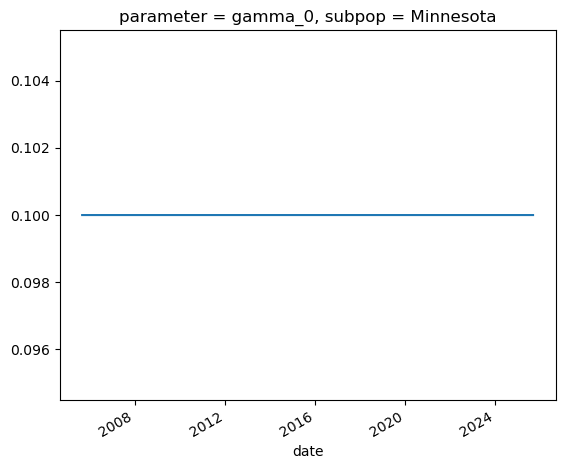

In [9]:
xr.DataArray(p_draw, dims=["parameter", "date", "subpop"],  
                coords={"parameter":modinf.parameters.pnames, 
                "date":pd.date_range(modinf.ti, modinf.tf, freq="D"), 
                "subpop":modinf.subpop_struct.subpop_names}).sel(parameter="gamma_0").plot()

In [10]:
# need to convert to numba dict to python dict so it is pickable
seeding_data = dict(seeding_data)

In [11]:
if False:
    outcomes_df = run_simulation(snpi_df_in=snpi_df_ref, hnpi_df_in=hnpi_df_ref)
    outcomes_df_ref.set_index("date")["incidH"].plot(lw=2, c='k')
    outcomes_df.set_index("date")["incidH"].plot(lw=1, c='r')

In [12]:
#proposal = np.random.random(size=ndim)
#print(log_prob(proposal))
#proposal = np.random.random(size=ndim)*2
#print(log_prob(proposal))

In [13]:
nwalkers = 32
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:,i] = fitted_params["pdist"][i](nwalkers)

In [14]:
#print(fitted_params["lb"])
#print(p0)
#print(fitted_params["ub"])

In [15]:
subpop="Minnesota"
gt_s = gt[gt["subpop"]==subpop]
gt_s.sort_index()

,subpop,incidH_0_0.99,incidH_18_49,incidH_1_4,incidH_50_64,incidH_5_17,incidH_65_100
date,,,,,,,
2008-10-11,Minnesota,NaN,0.0,NaN,0.0,NaN,0.0
2008-10-18,Minnesota,NaN,3.0,NaN,0.0,NaN,0.0
2008-10-25,Minnesota,NaN,0.0,NaN,0.0,NaN,0.0
2008-11-01,Minnesota,NaN,0.0,NaN,0.0,NaN,0.0
2008-11-08,Minnesota,NaN,0.0,NaN,3.0,NaN,0.0
...,...,...,...,...,...,...,...
2024-01-13,Minnesota,78.0,12.0,46.0,12.0,6.0,43.0
2024-01-20,Minnesota,74.0,10.0,22.0,12.0,0.0,50.0
2024-01-27,Minnesota,52.0,3.0,22.0,9.0,2.0,35.0


In [16]:
import emcee

from multiprocessing import Pool
from gempyor_logprob import log_prob, compute_likelyhood, check_in_bounds, run_simulation, input_proposal



print(f"initial llik {compute_likelyhood(outcomes_df_ref, gt, modinf, statistics)}")


initial llik -2476360.6425311686


In [17]:
fitted_params

{'ptype': ['snpi',
  'snpi',
  'snpi',
  'snpi',
  'snpi',
  'hnpi',
  'hnpi',
  'hnpi',
  'hnpi',
  'hnpi',
  'hnpi'],
 'pname': ['Ro_mod',
  'covid_mod',
  'omicron_mod',
  'seas_amp_mod',
  'seas_offset_mod',
  'IHRadj_age0to11m',
  'IHRadj_age1to4',
  'IHRadj_age5to17',
  'IHRadj_age18to49',
  'IHRadj_age50to64',
  'IHRadj_age65to100'],
 'pdist': [<bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15f9ff690>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15f9eb790>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15f9eb8d0>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15f9eb310>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15f9ea790>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continu

In [18]:
for i in range(nwalkers):
    assert check_in_bounds(p0[i], fitted_params)

In [20]:
filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool(nwalkers) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, 
                                    args=[snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters], 
                                    pool=pool,
                                    backend=backend)
    state = sampler.run_mcmc(p0, 50, progress=True)

INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.19 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] complete

llik is -2280735.844454064
llik is -2956635.7231337167
llik is -4438580.8697739225
llik is -4177558.077861718
llik is -7361761.397599231
llik is -2447536.2209110875
llik is -3871010.085012718
llik is -1936746.8812700368
llik is -2992590.0859797746
llik is -2402241.6479603904
llik is -2256847.826117205
llik is -2441619.103208206
llik is -2567845.9979695436
llik is -2542995.147786377
llik is -2487006.0022954624
llik is -3025669.5944288964
llik is -4203438.648128412
llik is -5961168.237691397
llik is -3228066.1845354787
llik is -2174945.266805943
llik is -2892004.119375089
llik is -2462740.7086681724
llik is -1532740.1051919146
llik is -11703971.833827281
llik is -2289258.929617633
llik is -2463166.1420845743
llik is -2201596.0284109474
llik is -1599998.286890816
llik is -1872603.7849535556
llik is -4043631.0203160816
llik is -2768760.430652992
llik is -2384753.735868226


  0%|          | 0/50 [00:00<?, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -2027221.1482051522
llik is -3401711.576035846
llik is -3062876.8251525257
llik is -2699034.3740071263
llik is -5399063.498124361
llik is -2263237.604120832
llik is -2815811.088870265
llik is -2283313.9778153948
llik is -2994927.1853111098
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.30 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrat

llik is -7370455.8974699965
llik is -2452616.244172027
llik is -1693450.49724418
llik is -2650877.622080449
llik is -2161254.906893335
llik is -2200303.357834284
llik is -2869508.4296555114
llik is -1944805.6813061398
llik is -2472809.264689819
llik is -2245500.9886242044


  2%|▏         | 1/50 [00:53<43:37, 53.42s/it]

llik is -2433266.863041078
llik is -1845486.5953081183
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
3653it [00:10, 349.13it/s]
3653it [00:10, 353.15it/s]
3653it [00:10, 347.28it/s]
3653it [00:10, 346.74it/s]
3653it [00:10, 345.56it/s]
3653it [00:12, 303.00it/s]
3653it [00:11, 313.71it/s]
3653it [00:11, 309.44it/s]


llik is -1919796.6912993332
llik is -2021221.0950730247
llik is -2402966.250543839
llik is -3350348.6795935226
llik is -2568960.242558974
llik is -1853269.1891802861
llik is -11299658.284901962
llik is -2257180.409496565
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[SEIR.NPI] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00

llik is -1227663.8811882276
llik is -1657887.6890037137
llik is -2619021.1409297013
llik is -2238335.8002510536
llik is -2888920.383510561
llik is -9913811.306861516
llik is -1658117.589269429
llik is -2410252.6375518106
llik is -2825306.177323913
llik is -2145838.7266531163
llik is -2705166.5798072536


  4%|▍         | 2/50 [01:45<41:54, 52.38s/it]

llik is -1939086.6515190322
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.05 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -3067496.724501043
llik is -2094298.7062122535
llik is -3805477.097646522
llik is -4630374.569465346
llik is -1816378.0790939901
llik is -2520884.449022532
llik is -1598006.171810307
llik is -2441518.3353008986
llik is -6153044.9208944375
llik is -2396968.6163292616
llik is -1689567.722069978
llik is -2411113.290694761
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
3653it [00:13, 276.28it/s]
3653it [00:13, 272.72it/s]
3653it [00:13, 269.98it/s]
3653it [00:14, 255.59it/s]
3653it [00:14, 260.48it/s]
3653it [00:14, 255.54it/s]
3653it [00:14, 260.83it/s]
3653it [00:15, 233.34it/s]
3653it [00:15, 229.92it/s]
3653it [00:15, 231.40it/s]


llik is -1952380.671755464
llik is -3434946.372909006
llik is -2476903.2069306234
llik is -1511937.7238342653
llik is -2286446.006228897
llik is -2349326.9191781417
llik is -3187985.531844595
llik is -17133688.619338237
llik is -1890534.9153181892


  6%|▌         | 3/50 [02:40<42:13, 53.90s/it]

llik is -6330386.473901676
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.03 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:In

llik is -3353586.492737772
llik is -2206599.0323510296
llik is -2483650.0472254707
llik is -3297847.297617104
llik is -2613361.7605595975
llik is -1564451.524356909
llik is -2437766.9066767134
llik is -1359668.7977439556
llik is -2638254.1375678834
llik is -3912377.02552044
llik is -2361567.0293926788
llik is -1653976.6155313782
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 

llik is -2079068.942869958
llik is -2454145.1226162077
llik is -3488530.0313191325
llik is -2308814.088895926
llik is -2218912.219443957
llik is -1393470.9210198568
llik is -8242710.600261925
llik is -10282140.645215683
llik is -2259297.5889057107
llik is -3177921.9373928285
llik is -2335579.21340431
llik is -1883030.6435722064


  8%|▊         | 4/50 [03:41<43:26, 56.67s/it]

llik is -3176200.295966504
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.24 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO

llik is -2576342.415642701
llik is -1865451.7848779487
llik is -1804681.4753497923
llik is -2147242.9676044467
llik is -2956059.0969951604
llik is -4286530.217257935
llik is -1712686.6749274756
llik is -4071583.8911923133
llik is -4551383.517530751
llik is -2143979.065113314
llik is -1736577.8336278785
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4

llik is -1637161.1555018078
llik is -2110362.937457256
llik is -15141829.181268672
llik is -4822445.814711042
llik is -2307834.409728828
llik is -2392239.1943489704
llik is -1616933.378313102
llik is -2050330.8191820243
llik is -2247754.355356597
llik is -2599122.8499266747
llik is -9464072.302762423
llik is -1331709.3665899057
llik is -1977359.767321503


 10%|█         | 5/50 [04:43<43:52, 58.50s/it]

llik is -2067951.5131887652
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:roo

llik is -2513464.0789009593
llik is -2326477.361406849
llik is -1862580.801505393
llik is -3069224.9476787494
llik is -2344811.7912621675
llik is -2005014.9054341058
llik is -2190023.8518294482
llik is -2212551.1552737267
llik is -2402323.0448026117
llik is -1762849.0800676774
llik is -2723738.9918307886
llik is -3490970.86724362
llik is -3281059.362070794
llik is -8570317.71713093
llik is -2122008.3184577124
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
3653it [00:13, 265.25it/s]
3653it [00:14, 247.16it/s]
3653it [00:14, 245.64it/s]
3653it [00:15, 239.02it/s]
3653it [00:15, 230.83it/s]
3653it [00:15, 229.26it/s]
3653it [00:15, 230.29it/s]
3653it [00:15, 232.27it/s]
3653it [00:16, 225.73it/s]
3653it [00:16, 222.38it/s]
3653it [00:16, 215.96it/s]


llik is -2799355.0032609827
llik is -3248066.1304160575
llik is -4554411.4960758155
llik is -1638846.6873844063
llik is -3542395.2092168173
llik is -1846802.4304968382
llik is -2022767.4786023495
llik is -2217983.3185396628
llik is -2032820.5366349956
llik is -2200598.0798444725


 12%|█▏        | 6/50 [05:48<44:35, 60.80s/it]

llik is -1619498.4314440265
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
3653it [00:12, 281.46it/s]
3653it [00:13, 264.41it/s]
3653it [00:13, 270.36it/s]
3653it [00:13, 266.76it/s]
3653it [00:14, 256.66it/s]
3653it [00:14, 254.85it/s]
3653it [00:14, 257.77it/s]
3653it [00:14, 258.39it/s]

llik is -2005099.5455301346
llik is -1643107.5574729207
llik is -1239180.8037498798
llik is -1127548.5065568273
llik is -1474055.1739620157
llik is -2538742.030407701
llik is -2106339.5374533273
llik is -1912027.1778509375
llik is -4106283.134503821
llik is -1793187.7195911352
llik is -4014665.502157262
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating w

llik is -9401158.014013272
llik is -2499711.081625946
llik is -2106579.4225015556
llik is -3199724.184730078
llik is -2547029.8250317704
llik is -2795871.9083626545
llik is -2215634.3820113936
llik is -1680246.8500423087
llik is -2736079.326783942
llik is -1442167.2618852446
llik is -2127751.6396255638


 14%|█▍        | 7/50 [06:47<43:11, 60.26s/it]

llik is -1468577.493991039
llik is -2355204.234682892


INFO:root:[SEIR.NPI] completed in 0.06 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.06 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00

llik is -2435860.2977825785
llik is -1374667.5146486498
llik is -1226573.7434499783
llik is -3109336.266391525
llik is -2056970.7417591016
llik is -2703597.11902992
llik is -2593310.613913192
llik is -2345974.5712748715
llik is -2218225.0936073186
llik is -1500182.9560984678
llik is -1614187.6838639935
llik is -1508596.7968928844
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[Outcome

llik is -2072420.5471926727
llik is -4402956.704338175
llik is -3045382.673055508
llik is -1512383.1202325313
llik is -2382281.00131758
llik is -1267052.1463357988
llik is -1806307.1835109391
llik is -3080714.8202981623
llik is -1701142.469061779
llik is -2201023.1940039224
llik is -1579386.7391984924
llik is -2924630.8190630376


 16%|█▌        | 8/50 [07:54<43:31, 62.18s/it]

llik is -1703750.0229898063
llik is -1358382.124217393
llik is -1755991.594669379


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s


OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with metho

llik is -2425397.938179748
llik is -2987931.345582327
llik is -2222814.7554769227
llik is -1777183.2045448776
llik is -1303220.5835484082
llik is -3609747.854863709
llik is -2217944.0612548385
llik is -2200151.8830235405
llik is -1616578.8032503738
llik is -1970370.8741224182
llik is -2801529.2671595775
llik is -2078035.68912723
llik is -1697745.8321608293
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:roo

llik is -2434306.6991616
llik is -2403230.750243781
llik is -1647049.6342208427
llik is -2189631.815403347
llik is -2627627.4106054623
llik is -4305271.67880137
llik is -1232448.601793167
llik is -2132182.8085996322
llik is -1869008.9210806566
llik is -3587701.2019838225
llik is -1875528.57228907
llik is -2013472.86369479


 18%|█▊        | 9/50 [08:58<42:52, 62.74s/it]

llik is -2178067.873686285
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.28 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
3653it [00:14, 254.05it/s]
3653it [00:14, 249.44it/s]
3653it [00:15, 238.25it/s]
3653it [00:14, 245.43it

llik is -1483660.1164431714
llik is -2690371.8933466077
llik is -1773199.0717836022
llik is -2114200.93527903
llik is -1784527.9625006951
llik is -1998484.626378413
llik is -1207789.5106185565
llik is -1288659.604940515
llik is -2171771.9898817665
llik is -2725298.6938672913
llik is -2408547.6048483467
llik is -2373963.585811738


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:roo

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
3653it [00:20, 180.96it/s]
3653it [00:19, 191.00it/s]
3653it [00:20, 178.11it/s]
3653it [00:21, 168.01it/s]
3653it [00:20, 179.08it/s]
3

llik is -2933277.9159986465
llik is -2423316.235902602
llik is -1983518.287560879
llik is -2552252.576701373
llik is -1592127.9216048722
llik is -2471020.649245877
llik is -3422664.121143884
llik is -2171324.311609779
llik is -2048278.7115712364
llik is -1519533.4058585835
llik is -1449462.4691075578
llik is -1683536.6809467769
llik is -1558972.851948655
llik is -2453613.748746769


 20%|██        | 10/50 [10:05<42:52, 64.31s/it]

llik is -1679458.735072496
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifier

llik is -1942696.406699812
llik is -2769665.8636180405
llik is -1533220.4766344312
llik is -2280683.617460121
llik is -1900423.9662785854
llik is -2452932.8170723408
llik is -3377953.785821083
llik is -5654564.070885916
llik is -1457971.0931289322
llik is -3425782.5117968125
llik is -1850063.6036315765
llik is -2679618.6574356514
llik is -2133130.464007555
llik is -3481984.3803046034
llik is -1617814.6662105136
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.06 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0

llik is -1431539.3665805147
llik is -1354816.2683717508
llik is -3133118.381981156
llik is -4223066.265115551
llik is -1503667.0770983452
llik is -2065800.2583465984
llik is -1634887.9484644288
llik is -2198702.9232246196
llik is -1850525.3091511973
llik is -1985462.9331640804
llik is -1512399.612054688
llik is -1990974.1674032493
llik is -1449614.1927098953


 22%|██▏       | 11/50 [11:17<43:19, 66.65s/it]

llik is -2114168.316099657


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0i

llik is -1596743.0804464815
llik is -1666947.3055982487
llik is -1321117.7637396147
llik is -2453837.8165011057
llik is -1697645.264802027
llik is -2357967.325684224
llik is -2159806.8529580743
llik is -2007638.429807274
llik is -1646621.3974569526
llik is -2018917.4318443688
llik is -2470274.537627832
llik is -3710912.7728759786
llik is -1321394.762608708
llik is -2391515.3052702686
llik is -2053272.9238136183
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
3653it [00:15, 232.61it/s]
3653it [00:16, 227.92it/s]
3653it [00:16, 222.74it/s]
3653it [00:16, 220.28it/s]
3653it [00:16, 218.63it/s]
3653it [00:16, 220.26it/s]
3653it [00:17, 212.04it/s]
3653it [00:17, 211.38it/s]
3653it [00:16, 216.79it/s]
3653it [00:17, 211.07it/s]
3653it [00:17

llik is -1260972.697798283
llik is -2735275.389003187
llik is -1854927.1977427008
llik is -1674784.840929109
llik is -1530381.5370928952
llik is -2307759.9521791195
llik is -3185728.9983203313
llik is -2066376.3388501566
llik is -1787610.399910999


 24%|██▍       | 12/50 [12:24<42:17, 66.78s/it]

llik is -2011893.073556952
llik is -1680151.1947503616
llik is -1696572.882799644


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00

llik is -1191649.3439364708
llik is -2413068.8698902423
llik is -2780372.9101215214
llik is -2226666.9504957637
llik is -1958559.298339733
llik is -1276237.2070706412
llik is -1282332.0022146313
llik is -2043864.4328654357
llik is -2425970.1898404006
llik is -2203807.649790411
llik is -4681848.026996021
llik is -1642509.4577401504
llik is -2285991.5705687697


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating 

llik is -1826557.345793223
llik is -1756883.0715506899
llik is -1335484.1974638694
llik is -2451190.184724648
llik is -1252989.3587523103
llik is -2191589.268947492
llik is -2957134.454280803
llik is -2584058.811438347
llik is -3020162.1447395463
llik is -2128923.8310717796
llik is -1745758.0911325712
llik is -1626417.4663368654
llik is -3495901.3545383434


 26%|██▌       | 13/50 [13:35<41:51, 67.89s/it]

llik is -2139689.861606658
llik is -1278249.1042178893
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[SEIR.NPI] completed in 0.06 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
1it [00:01,  1.64s/it]/s]INFO:root:Integrating with method rk4.jit
3653it [00:14, 250.68it/s]
3653it [00:14, 255.29it/s]
3653it [00:15, 239.36it/s]
3653it [00:14, 245.44it/s]
3653it [00:14, 249.98it/s]
3653it [00:15, 231.21it/s]
3653it [00:15, 240.50it/s]
3653it [00:15, 236

llik is -1596697.4439219832
llik is -2510635.8186274054
llik is -2667193.3133213436
llik is -2405387.9514481276
llik is -1280136.2447457933
llik is -1904689.9362221756
llik is -1548711.2438821448
llik is -1537506.078184729
llik is -2343697.320726679
llik is -1781628.3180119772
llik is -2392418.899026292
llik is -1669130.47118661
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 

llik is -1331680.151785142
llik is -1483771.3918521914
llik is -1123594.7747114468
llik is -2371576.780275847
llik is -2351209.3733629505
llik is -1992935.065482569
llik is -2147807.028328561
llik is -2550232.767953694
llik is -2188263.587937922
llik is -2285478.749763428
llik is -1474258.0547386396
llik is -2064439.80860044
llik is -3587309.0411913423
llik is -1420782.6125562368


 28%|██▊       | 14/50 [14:47<41:31, 69.21s/it]

llik is -2091252.9900170641


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifier

llik is -1445109.6657412664
llik is -1831687.245338562
llik is -2415574.892987562
llik is -1740464.1851943547
llik is -1445062.4731684146
llik is -1281640.5068307102
llik is -4870559.487379939
llik is -1361407.1099965563
llik is -2092733.9548466806
llik is -1636307.1738023097
llik is -2377556.0782252015
llik is -2645030.3153353916
llik is -1832415.7129312474
llik is -1226688.0421431998
llik is -2032033.469402628
llik is -1429811.501899521
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] complete

llik is -2422023.5790013405
llik is -1541780.7816881638
llik is -1212708.9635465005
llik is -1207174.4833668151
llik is -1717122.865692661
llik is -1647848.811241677
llik is -1492016.7164561308
llik is -1587533.0261055876
llik is -1713614.6124729328
llik is -1644982.8445479353
llik is -2118243.6915108413
llik is -1513341.3666597197
llik is -2348208.6878110976


 30%|███       | 15/50 [16:10<42:48, 73.40s/it]

llik is -1548945.9299946406


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:

llik is -2350349.2721695458
llik is -1543647.7539804222
llik is -1211853.5702529426
llik is -2373166.2328722635
llik is -1651401.6451183732
llik is -1147797.0432317182
llik is -2408335.6033503274
llik is -1465523.4020061821
llik is -2239756.222619538
llik is -1352234.8430292457
llik is -1236978.3639556514
llik is -1583428.4037599638
llik is -1648455.4748217522
llik is -2293925.1694762115
llik is -1445796.6390071786


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:roo

llik is -2689202.1118684835
llik is -2035013.2398677103
llik is -2645086.601107436
llik is -1424038.0079269563
llik is -2630260.0934366547
llik is -1742541.8302788476
llik is -2506178.4441619995
llik is -1589391.0846902404
llik is -1985914.931399353
llik is -3538143.362086047
llik is -1447679.8823735667
llik is -2036411.5718754076
llik is -1266720.9136764307
llik is -1623531.1982548
llik is -1429175.370266701


 32%|███▏      | 16/50 [17:30<42:45, 75.45s/it]

llik is -1671378.6362023498
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 

llik is -1596076.101172929
llik is -1348869.926868508
llik is -1495429.5911917754
llik is -1826649.7925563988
llik is -2203321.5011072825
llik is -1724479.4069049447
llik is -1306560.1674719132
llik is -1819179.0849069427
llik is -2592049.78489974
llik is -1547073.1943852415
llik is -1857901.6055399089
llik is -1183879.1741472657
llik is -2028226.0513322314
llik is -2543260.1693848255


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrati

llik is -1251407.819972874
llik is -2454546.900726444
llik is -1321965.1909761564
llik is -2500291.216804946
llik is -1053402.678733028
llik is -1706434.1497543044
llik is -2033484.5748399831
llik is -1357898.6677496813
llik is -1252800.7998133078
llik is -1126951.5946774636
llik is -1823327.088375112
llik is -1531537.2785584196
llik is -1502891.8915600395


 34%|███▍      | 17/50 [18:38<40:11, 73.06s/it]

llik is -2031472.532216504
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 

llik is -2538696.555400398
llik is -2106046.665318851
llik is -1841311.8592726416
llik is -2502824.4877096633
llik is -5236187.576501847
llik is -1614644.9190819482
llik is -1743559.0617993695
llik is -1747893.5733524717
llik is -1647961.2164733731
llik is -2655633.0405828673
llik is -1725832.546899802
llik is -1895672.9827783278
llik is -1429923.6056382104
llik is -2370121.938228332
llik is -1443205.0685386455


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:roo

llik is -2480462.746699695
llik is -1034858.5818815129
llik is -1635991.1900166005
llik is -1157582.7255842362
llik is -1222427.2042979705
llik is -1344920.06575353
llik is -1186860.0897142221
llik is -2214557.149213631
llik is -1759349.9339538498
llik is -2519859.0063341167
llik is -1294108.4473157371
llik is -1890102.3248743534
llik is -1280663.8467560727


 36%|███▌      | 18/50 [19:59<40:09, 75.31s/it]

llik is -2017375.75504703
llik is -2256620.600557989
llik is -1335492.2476824424


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.64 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.62 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:

llik is -1044957.4753777704
llik is -1419031.0831904698
llik is -2281116.3300638483
llik is -1925323.5821056035
llik is -1842467.4251415895
llik is -1761346.0199197887
llik is -2523241.183156757
llik is -2115932.1714567416
llik is -1097780.2302298967
llik is -1934296.9773559705
llik is -2192161.3930195174
llik is -1400732.2630551485
llik is -1933393.4281662158
llik is -3475377.221610941
llik is -1451479.7009645829
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers

llik is -2643700.0347405886
llik is -1272270.3824050932
llik is -1458927.3158370627
llik is -1626464.2497650909
llik is -2104486.3424200164
llik is -1174501.1751928672
llik is -1960382.9629692992
llik is -2350882.3620764646
llik is -1245293.7917286179
llik is -1557859.2702476378
llik is -1280474.6384012194
llik is -1385276.4843303836


 38%|███▊      | 19/50 [21:16<39:14, 75.95s/it]

llik is -1713670.2386667263
llik is -1223137.2507460457
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with metho

llik is -2504243.326723963
llik is -2991887.755870323
llik is -1118081.7549697473
llik is -2091657.3838017986
llik is -1585518.4364151729
llik is -1591845.4067620481
llik is -1501651.0033317367
llik is -1113825.184185229
llik is -1383880.557032533
llik is -1550122.4285562353
llik is -3574544.4478753405
llik is -1581864.156675867
llik is -1479658.7844327467
llik is -1444017.0185017441


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcome

llik is -1628087.815901228
llik is -1371383.768293448
llik is -1552397.6497060137
llik is -2281209.42670964
llik is -1302057.048888378
llik is -1583923.0193046518
llik is -1241937.4623477757
llik is -1068633.7324986428
llik is -2211739.1025476754
llik is -2869223.214972838
llik is -1547194.380427376
llik is -2423826.072575861
llik is -2233627.6966285487
llik is -1650869.237573916
llik is -1198327.8873791962


 40%|████      | 20/50 [22:35<38:24, 76.83s/it]

llik is -1963273.7086066054
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:roo

llik is -2335867.458798981
llik is -2509291.24940333
llik is -1338464.7414629043
llik is -1194624.5119289462
llik is -1524383.4873719187
llik is -2249633.177770741
llik is -1260725.141991552
llik is -1781720.540345178
llik is -2442545.4704703493
llik is -1265935.9420137987
llik is -1517078.929162185
llik is -1259498.0280169223
llik is -1372985.7058028444
llik is -1176479.7541190675
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] complete

llik is -1144398.9055061454
llik is -1190530.6441066393
llik is -1400865.673779029
llik is -1787268.9244853393
llik is -1548347.654877667
llik is -2629813.1417962965
llik is -1190670.2840183685
llik is -1511121.7310773607
llik is -1879272.199304963
llik is -3371579.5968228765
llik is -1243467.3695031162
llik is -1426938.0050074775
llik is -2702000.1301041762
llik is -1835846.4488625454


 42%|████▏     | 21/50 [23:45<36:12, 74.90s/it]

llik is -1938407.7741245525
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 

llik is -1280307.2838024732
llik is -1343338.6790050692
llik is -1226416.453612303
llik is -2336678.0445517874
llik is -1176038.4167244262
llik is -1801908.7900051142
llik is -1270112.998352236
llik is -2286966.5629108953
llik is -2396054.523016553
llik is -1391242.772788552
llik is -1612214.3618547693
llik is -2309819.6415162305
llik is -1541539.6980090858
llik is -1171837.3285594175
llik is -1092002.549476998


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers

llik is -1556962.1665560561
llik is -1622500.6469516023
llik is -1305873.6719720126
llik is -1870048.7023480448
llik is -3152734.8824245976
llik is -2400519.401680322
llik is -2490250.781775926
llik is -1487056.8062218407
llik is -1095895.1455087399
llik is -2438198.5075647873
llik is -1476134.5552985359
llik is -991008.0301840657


 44%|████▍     | 22/50 [24:57<34:32, 74.01s/it]

llik is -1487997.5165194883
llik is -3832157.0569142513
llik is -1945153.3477671708


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrati

llik is -1146475.0536366496
llik is -1150784.0611337535
llik is -1352071.5017661715
llik is -1643891.0503556048
llik is -1400097.1285605344
llik is -1734025.8876826914
llik is -1703892.0922581977
llik is -1440264.7710062214
llik is -4625358.985006942
llik is -2050195.5205379664
llik is -1674841.1115103236
llik is -4628717.718637994
llik is -1283715.7288496383
llik is -1470735.9957249158
llik is -1225037.639229557
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:Integrating with me

llik is -1275822.9929467472
llik is -1319707.1412519242
llik is -2394024.37796143
llik is -1480447.5382280448
llik is -2347289.937881285
llik is -2395773.060143091
llik is -1325719.566554208
llik is -1269085.7769285152
llik is -2040995.3450648282
llik is -1515856.0335046777
llik is -2437312.520414157
llik is -2444387.3158301767
llik is -1433258.7855931488


 46%|████▌     | 23/50 [26:08<32:48, 72.91s/it]

llik is -1512515.0065485656
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:roo

llik is -1493897.672581708
llik is -1481139.8100199194
llik is -2373517.4251443185
llik is -1053770.1469538768
llik is -1862615.9558059694
llik is -2577469.0763633684
llik is -1552093.4478320896
llik is -1439840.805203004
llik is -2409667.1884094547
llik is -1221930.1688554778
llik is -1449913.9351951177
llik is -1199428.9029204235
llik is -1326865.3365219012
llik is -1694574.5661556355
llik is -1448105.1474889868
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:Integrating with me

llik is -1109513.121240274
llik is -1239812.6424064103
llik is -1597919.548659863
llik is -1166454.1446641567
llik is -2332948.802248176
llik is -1355456.9980934488
llik is -1040464.0756122237
llik is -1717283.271716022
llik is -1453850.0462282468
llik is -1175281.756410353


 48%|████▊     | 24/50 [27:17<31:12, 72.02s/it]

llik is -1187283.7202119927
llik is -1073592.0335716493
llik is -2192546.239209709
llik is -1561679.3701676317


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

llik is -1174117.6975088087
llik is -1930785.4611930922
llik is -1152357.0657695527
llik is -2411832.0008708984
llik is -1176150.5706823915
llik is -1331222.1362804996
llik is -2306898.422023714
llik is -1666179.605127584
llik is -1407430.2981993416
llik is -1319922.2508582766
llik is -2419433.4993269593
llik is -1134246.402377661
llik is -1133315.431198499
llik is -1215436.8115067359
llik is -1074310.7316843292


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:Integrating with me

llik is -1503077.0205777434
llik is -1156009.9482552726
llik is -2925826.6347344955
llik is -2320184.589900136
llik is -2129635.914077718
llik is -1234236.3235116557
llik is -1006348.6914852312
llik is -1043498.1978286424
llik is -1312992.0628091178
llik is -1676877.0368587943
llik is -1106066.9803581953
llik is -1876508.128182063
llik is -1482008.7985756318
llik is -1735527.3598885918


 50%|█████     | 25/50 [28:28<29:52, 71.71s/it]

llik is -3055839.373638033


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
107it [00:02, 81.

llik is -2350909.6609339546
llik is -1236069.985394211
llik is -2344379.6208337266
llik is -1398986.3110933737
llik is -1327293.6544111606
llik is -1270670.1283444113
llik is -1385258.6717766481
llik is -1166269.8588411517
llik is -2938066.752689128
llik is -1577248.9981576875
llik is -1148566.1664413202
llik is -1619306.2376699604
llik is -1231262.8349246194
llik is -1361743.918656037
llik is -1151671.7583450167


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:roo

llik is -2330622.5298229903
llik is -1103868.9877050542
llik is -2509311.333978941
llik is -2680690.2468198827
llik is -1211369.6464441295
llik is -949937.4454115839
llik is -1630195.890702887
llik is -2198677.021235136
llik is -1119990.7303587582
llik is -1410767.4024867502
llik is -1618076.233386031
llik is -1543417.1051457017
llik is -1111509.8918703736


 52%|█████▏    | 26/50 [29:43<29:04, 72.68s/it]

llik is -1259567.634117258
llik is -1130791.7643039546
llik is -1492538.9708511927


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.28 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:0

llik is -1153249.3810924655
llik is -2326296.8142586485
llik is -1040154.0115248518
llik is -1820854.100018281
llik is -1167694.6539733463
llik is -1225718.2716346371
llik is -1164962.318494167
llik is -1131329.591306927
llik is -1214258.983619323
llik is -1263784.5547101344
llik is -2493067.2237436287
llik is -1289191.5222011462
llik is -1377326.5229088208
llik is -1482869.9482934084
llik is -1425068.7788150164
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[SEIR.NPI] completed in 0.06 

llik is -2431996.9928675974
llik is -2376709.7162857773
llik is -1136746.8524352442
llik is -1185436.604880969
llik is -1065332.3695632648
llik is -1432192.197124387
llik is -959395.672505672
llik is -3912829.048484586
llik is -1149341.057770314
llik is -2804016.801105735
llik is -2194422.6536893407
llik is -1593786.01376064
llik is -1233320.1125566142


 54%|█████▍    | 27/50 [30:55<27:46, 72.47s/it]

llik is -2912775.904432869
llik is -1243963.8450721418


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[Outcomes.Modifiers

llik is -1397760.7538023735
llik is -2371864.445017511
llik is -1152386.446857182
llik is -1336128.7848663907
llik is -2215370.942338799
llik is -1929575.6697225177
llik is -2347519.706339977
llik is -1148574.6364789666
llik is -2178813.2536003347
llik is -1273823.8956246045
llik is -2512418.686747513
llik is -1531833.8700866234
llik is -2295962.0391438603
llik is -2114653.715735776
llik is -1319546.3131819877
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.49 

llik is -2354975.261713276
llik is -1289951.2085744939
llik is -2274221.1239046683
llik is -1561321.0252439713
llik is -1106214.5514882319
llik is -1118968.4494393321
llik is -1756064.3425073058
llik is -2434165.739359789
llik is -1171395.8387167933
llik is -1515747.9181081448
llik is -1294438.2089012978
llik is -1047491.0742035798
llik is -1197699.0765115065
llik is -1508794.125295009


 56%|█████▌    | 28/50 [32:07<26:25, 72.07s/it]

llik is -1380787.4106188265
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 

llik is -2545763.211722174
llik is -1071577.3125415174
llik is -2293851.5020888825
llik is -2137690.5781659917
llik is -1469449.6824107054
llik is -1071748.3271148256
llik is -2632475.304466086
llik is -1394892.932213834
llik is -1525764.3613806295
llik is -1275751.5253921014
llik is -942090.3482827406
llik is -1283222.7631613552
llik is -2341533.609608012
llik is -1114765.6727563576
llik is -1179546.6515811565


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 

llik is -1463868.9658230918
llik is -1309439.6341014104
llik is -2442059.393902995
llik is -1843595.9155075084
llik is -1057034.868409056
llik is -2517937.2061911034
llik is -1052267.0457798862
llik is -1030278.8777636301
llik is -1065796.7080998993
llik is -1737065.4444095348
llik is -1502479.2474138024
llik is -1493026.3374720775
llik is -1539505.7578531844
llik is -1389482.89506755
llik is -1471077.4446074646


 58%|█████▊    | 29/50 [33:20<25:22, 72.49s/it]

llik is -1125738.1751973412
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.73 

llik is -1066438.3287702785
llik is -2358684.3030496337
llik is -1238059.8425842316
llik is -1106485.2941659088
llik is -1609434.6497824015
llik is -1273451.0853439437
llik is -1676394.7993920932
llik is -1393145.3312350821
llik is -959463.7183533331
llik is -1236698.886416827
llik is -1211935.85169918
llik is -2378757.8085309886
llik is -1032671.1104868542
llik is -1142627.3212270928
llik is -1357681.8373411673
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers

llik is -1132767.3792407447
llik is -2078461.645442428
llik is -2291462.2049219795
llik is -1266280.6129566964
llik is -1121253.3778649964
llik is -1048915.2458786992
llik is -1000788.8214463019
llik is -1030039.9981279683
llik is -1296198.709657215
llik is -1498368.6486619008
llik is -1067174.8727991187


 60%|██████    | 30/50 [34:38<24:39, 74.00s/it]

llik is -1170529.197078369
llik is -1838503.0505707439
llik is -1093286.8948875559
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:roo

llik is -1464914.5555707088
llik is -2744340.5369764934
llik is -1134075.5258551114
llik is -1126887.194186523
llik is -1096422.8886518527
llik is -1824614.6994667454
llik is -2335550.268781762
llik is -1038950.9445237323
llik is -1183856.1681430477
llik is -1068164.2189071784
llik is -1105247.7393727284
llik is -1051331.6861413023
llik is -2005333.0465653557
llik is -2184447.847631411


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.58 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:Integrati

llik is -1381526.4099016106
llik is -3112417.8244998036
llik is -1855645.2289678783
llik is -1218841.8689406044
llik is -1781577.55260553
llik is -1749392.0031569542
llik is -2253438.05464354
llik is -1182663.9358088104
llik is -1218793.6996523312
llik is -1441901.99583583
llik is -1369024.0184923476
llik is -1079960.8018269152
llik is -1467934.1628198
llik is -1094635.2009141026


 62%|██████▏   | 31/50 [35:52<23:30, 74.22s/it]

llik is -1179554.0432982286


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with metho

llik is -1093098.802172567
llik is -1488122.1081183313
llik is -1091945.3890473773
llik is -1456493.6749013176
llik is -1004693.4766836478
llik is -2368118.7127422253
llik is -1018365.1980631044
llik is -956866.1523083133
llik is -2430370.5607594303
llik is -1065561.3316314805
llik is -1106363.5549077068
llik is -1127182.1975006582
llik is -1054557.9105776823
llik is -1543833.6960481189
llik is -1449871.8674365443
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 

llik is -1782417.8246320956
llik is -1123439.1699166098
llik is -1047390.7447225905
llik is -1372214.4714190033
llik is -1535509.2007775768
llik is -1500044.0660513411
llik is -1157963.1554356974
llik is -1084784.2822139414
llik is -1660027.182221545
llik is -1365354.0940940534
llik is -1328162.82319572
llik is -1234536.45736331
llik is -2325211.144416069
llik is -1500652.733428428


 64%|██████▍   | 32/50 [37:05<22:10, 73.91s/it]

llik is -1052198.658742658


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 

llik is -1497851.1909872526
llik is -3042863.1731705843
llik is -1343806.338576956
llik is -1350961.3512815076
llik is -1168094.1082875568
llik is -1057420.7708869355
llik is -1961911.176626175
llik is -1309179.9113087615
llik is -1449641.5187676726
llik is -1397944.6313107295
llik is -2930288.8320877915
llik is -1193234.5245040397
llik is -1623568.1925008052
llik is -2311871.1029123045
llik is -1073013.7948632105
llik is -1208495.917866271
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] complete

llik is -1120285.6374091115
llik is -2290681.755496455
llik is -1189104.7493087943
llik is -1067925.2673103602
llik is -1102754.5872467174
llik is -1759088.72637312
llik is -2184028.2079822365
llik is -2128325.2893963098
llik is -1035680.2399688447
llik is -1151837.86719338
llik is -1151150.2389702038


 66%|██████▌   | 33/50 [38:22<21:07, 74.56s/it]

llik is -1031804.6497666293
llik is -1093565.9291325503
llik is -1127349.9054264997
llik is -1111347.8866486044


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:

llik is -1091998.0787590684
llik is -1080546.7439571219
llik is -2296757.703418302
llik is -1120479.9993683966
llik is -1497930.034177619
llik is -1151746.6864237986
llik is -1065055.586358321
llik is -1036262.7459854325
llik is -1019369.9407949401
llik is -1566665.2433775733
llik is -1520221.9133382551
llik is -1056767.7601307575
llik is -1514958.6968805469
llik is -2203617.4949343232
llik is -1345385.0619843164


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 

llik is -2308819.6381559954
llik is -1036779.5135275869
llik is -1360765.5883004803
llik is -934003.3123772619
llik is -1934516.3553622344
llik is -1105859.6035616542
llik is -1071800.770707928
llik is -1140149.970785266
llik is -1731103.5253229025
llik is -1365536.0801442869
llik is -1138583.1324322752
llik is -1440904.4862611375
llik is -1238209.7224988984
llik is -1255170.5492655388
llik is -1136783.7109191606


 68%|██████▊   | 34/50 [39:36<19:54, 74.67s/it]

llik is -1052999.0951580747
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with me

llik is -2283116.956292601
llik is -1153841.5089787566
llik is -1498465.7407373737
llik is -1034689.0398961876
llik is -1784956.3361683353
llik is -1050475.1988159523
llik is -1093368.5287748764
llik is -1349234.4945328925
llik is -1049742.0373096955
llik is -1465264.1210606904
llik is -1261160.1630783854
llik is -1135961.1713158519
llik is -1161872.874289016


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:roo

llik is -2046642.6631937213
llik is -1454266.8456144035
llik is -2295127.9514858183
llik is -1312127.037334295
llik is -1116184.2248570586
llik is -2840349.5001505804
llik is -993410.9374635167
llik is -1032914.5817821331
llik is -1067636.6267233982
llik is -1281639.0087592346
llik is -1182921.6069050245
llik is -1259286.0611383303
llik is -1104673.789135472
llik is -1129562.850652331


 70%|███████   | 35/50 [40:47<18:21, 73.45s/it]

llik is -1029733.8274456324
llik is -1098144.876258329


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.05 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:In

llik is -2092683.145277985
llik is -1513890.525267038
llik is -1259232.3267125732
llik is -1117967.9761865642
llik is -1086838.0719979284
llik is -1099904.5552600294
llik is -2252591.573012288
llik is -2224609.7311047874
llik is -1013774.4729659008
llik is -1150514.462582269
llik is -1421373.499660889
llik is -1011001.9615626677
llik is -1474429.292015653
llik is -1789607.1247247357


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] complete

llik is -1158043.3353031927
llik is -1486409.6448806496
llik is -1295976.3677571584
llik is -1066349.235692476
llik is -2315478.4112862702
llik is -1733568.3419306118
llik is -988339.4172101998
llik is -948518.5122748192
llik is -1019211.7151811516
llik is -1246207.6305219892
llik is -2973190.2672676784
llik is -1156278.2199183996
llik is -1136207.841164334
llik is -1158988.494221288


 72%|███████▏  | 36/50 [42:00<17:08, 73.44s/it]

llik is -1132523.3323886096
llik is -1069796.4184037473
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 

llik is -1135695.751905746
llik is -2183618.5195015976
llik is -1010368.4226349844
llik is -1538206.326511283
llik is -1041056.5401848537
llik is -2167250.7971395496
llik is -1273646.4888514425
llik is -1353926.3930554704
llik is -1257973.3547125615
llik is -1047381.5004166949
llik is -1061345.3398081728
llik is -1049493.079812315
llik is -1091861.1870496576
llik is -1012502.6783913419


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating 

llik is -2092660.9142635493
llik is -1049610.5158387448
llik is -1440228.52675145
llik is -1287592.6688344677
llik is -1968806.3196683703
llik is -1387195.6517398765
llik is -1003196.1301798187
llik is -1007741.4686968334
llik is -1344579.2572322283
llik is -1182412.1531157205
llik is -1480453.231470863
llik is -1226866.9754429734
llik is -1071714.2057237437
llik is -1160496.7089474977


 74%|███████▍  | 37/50 [43:11<15:44, 72.67s/it]

llik is -1071664.6880909652


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with me

llik is -2099439.848769664
llik is -2120327.002824905
llik is -1479727.7235168994
llik is -1024686.1078144141
llik is -1388318.0794651303
llik is -1116462.1974592984
llik is -1141286.337354992
llik is -1016864.4622396916
llik is -1605320.118971504
llik is -1317585.1438028507
llik is -2408744.0642475584
llik is -1346146.2402039373
llik is -1112880.3854014433
llik is -1146670.4126701022
llik is -1084234.760434686


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 

llik is -1258829.5428456545
llik is -1026566.3075644192
llik is -1201280.888816169
llik is -993533.0879458732
llik is -1025087.7222576299
llik is -1032715.2749408722
llik is -2156411.147976162
llik is -1369850.5491439214
llik is -1021379.2772374308
llik is -1531747.7771549139
llik is -1012226.4855944124
llik is -1087962.33636844
llik is -1124248.409140678
llik is -996334.4133208044
llik is -1941216.7936020494
llik is -1278655.9768773194


 76%|███████▌  | 38/50 [44:28<14:44, 73.72s/it]INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:[Outcomes.Modifiers

llik is -1074863.803004237
llik is -1088419.9747952588
llik is -1081553.8049333664
llik is -1086908.6390752012
llik is -2107030.5101247616
llik is -1121468.55968124
llik is -1488467.2401546184
llik is -1056911.408850129
llik is -1162645.3812208655
llik is -1706464.6210315581
llik is -1013161.0247615136
llik is -1075318.7864846955
llik is -1294268.5293309086
llik is -1073903.1332721426
llik is -1021559.9067207696


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:roo

llik is -1092592.165596513
llik is -1191401.4053429978
llik is -2085505.8847971798
llik is -1316152.2168244456
llik is -1012300.667452774
llik is -1032583.2034750482
llik is -1227899.5235535612
llik is -1420374.0893761965
llik is -1092460.7833901693
llik is -1216342.829552517
llik is -1200009.39818153
llik is -1020676.7226833096


 78%|███████▊  | 39/50 [45:45<13:44, 74.97s/it]

llik is -994473.3165157442
llik is -2432681.764963311
llik is -1364684.71706888
llik is -2108244.364148303


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] complete

llik is -1039665.7153331754
llik is -1922125.1172750872
llik is -1483401.1432413636
llik is -1928586.2434739375
llik is -961453.3036627455
llik is -1045227.1136012676
llik is -1368041.2672616048
llik is -1058873.130915484
llik is -1051631.7999105966
llik is -1036280.7829008801
llik is -1318930.810533927
llik is -991769.3060178309
llik is -1018065.9507938193
llik is -975643.3888118095
llik is -1120086.056427263
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 

llik is -995957.4727119128
llik is -2121555.661002828
llik is -1014280.0211600673
llik is -2134215.0874791667
llik is -1022812.3409990533
llik is -1112545.185579562
llik is -1306343.2797087412
llik is -1267235.2031461606
llik is -1488850.2069532517
llik is -1068553.8707027463
llik is -1111875.1160888204
llik is -1163296.6731081537
llik is -1556428.061837727


 80%|████████  | 40/50 [47:00<12:28, 74.85s/it]

llik is -1193686.357275255
llik is -1042330.8191818482


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 

llik is -2088468.952111744
llik is -1030212.6480015889
llik is -1903183.710807282
llik is -1432186.1701082645
llik is -4059539.355369502
llik is -1055948.7621155484
llik is -997773.198296642
llik is -1006657.4968821916
llik is -1533058.718270598
llik is -1054891.56561109
llik is -1057717.845044512
llik is -1342677.997069244
llik is -1143383.8851816375
llik is -1021613.5745453548
llik is -1083968.2409610474
llik is -1515655.2025278877


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.06 

llik is -2105633.552595925
llik is -1018964.8607805779
llik is -1000691.7456267725
llik is -1363400.7223377798
llik is -1024453.0136219151
llik is -1088903.890739898
llik is -1011474.7252785049
llik is -2130790.0310056284
llik is -997825.9937970722
llik is -1062478.0895798656
llik is -1036073.3332726681
llik is -1141308.4525543875
llik is -2660647.9223460346
llik is -1669385.352022367
llik is -1092016.197641858


 82%|████████▏ | 41/50 [48:23<11:35, 77.31s/it]

llik is -972745.257814064


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:roo

llik is -1482360.0903114874
llik is -1153141.4262497122
llik is -2207217.167975962
llik is -1041921.6001433533
llik is -1468246.1388789716
llik is -2144598.4337159726
llik is -1099509.7679954863
llik is -1038779.9626029222
llik is -2130431.3550012168
llik is -2876294.9238023986
llik is -1001979.7752219333
llik is -967164.1956904741
llik is -994315.9441803644
llik is -1129238.837289563
llik is -1262556.8321254137
llik is -1042381.439129366


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 

llik is -1066867.648643577
llik is -1395264.1735514896
llik is -1051449.5874213474
llik is -1038683.9375805368
llik is -1011327.2899807354
llik is -1338382.6883721293
llik is -989676.6514265852
llik is -1161965.7578929209
llik is -1151452.3603858612
llik is -1135697.6223746233
llik is -1047940.7940620814
llik is -977348.7879811785
llik is -1469943.0792219143
llik is -1235129.677135275


 84%|████████▍ | 42/50 [49:46<10:32, 79.10s/it]

llik is -1022834.1918858781
llik is -1147863.1934337884


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.68 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?

llik is -997120.5300570653
llik is -1335194.1216613322
llik is -1072292.0873051966
llik is -2120919.8618105114
llik is -946959.3660166916
llik is -928517.1252319223
llik is -1840797.8552787022
llik is -2111628.108213595
llik is -1051358.6004237628
llik is -3113878.690095248
llik is -1180873.1676448577
llik is -1215169.2582234086
llik is -1515596.7292666943
llik is -1002614.2178435847
llik is -1115504.5389971044


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers

llik is -1339307.9520859043
llik is -1118951.8802044347
llik is -1085564.4937904081
llik is -1009612.9290602504
llik is -1022118.0694217368
llik is -1477570.9467272672
llik is -1351996.7963269302
llik is -1145955.88663072
llik is -964932.6297859232
llik is -1211375.5563728092
llik is -1024622.8311274289
llik is -1068507.7953206582
llik is -1043179.9195835966
llik is -1019370.7613098321


 86%|████████▌ | 43/50 [51:05<09:12, 78.96s/it]

llik is -997196.4142960109


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcome

llik is -1857853.5357092577
llik is -1931314.447474887
llik is -1994141.6530168713
llik is -1180528.0146155506
llik is -2737386.866517429
llik is -1004356.9105696522
llik is -1000613.3557988611
llik is -1193795.7424392714
llik is -1099988.3697942027
llik is -1059015.959703179
llik is -984296.5141008185
llik is -959552.7958754657
llik is -1060744.277017531
llik is -994687.8462283162
llik is -1149535.5452500328
llik is -1130315.9136535288


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.56 

llik is -1226103.6438575413
llik is -1561009.4429782473
llik is -1043891.5502466802
llik is -2107211.5648645503
llik is -1020172.6373457977
llik is -1393326.5795470662
llik is -1423765.7056822916
llik is -1182767.4538383044
llik is -1057007.586145625
llik is -1046141.4239012018
llik is -1088749.8648470796
llik is -1140394.180213281


 88%|████████▊ | 44/50 [52:24<07:54, 79.10s/it]

llik is -1048681.5575858029
llik is -1392828.5922831665
llik is -1006052.2828032891
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 

llik is -1841594.6023879834
llik is -985810.0963881157
llik is -1021690.3421015337
llik is -1156694.5015782986
llik is -1013061.2313224796
llik is -980973.747451654
llik is -964071.13043136
llik is -1849748.7106755706
llik is -1061673.385611499
llik is -1076932.0932929895
llik is -1046679.0968766354
llik is -1241832.7627049866
llik is -979621.1669455995
llik is -1041266.0671954826
llik is -1086109.1078806666


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.70 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Int

llik is -1061042.924959476
llik is -1092005.7555966552
llik is -1003945.0530023634
llik is -1035267.5481889282
llik is -1910620.242224705
llik is -1735820.3489159339
llik is -1004997.7770368044
llik is -1017127.3760306722
llik is -1439420.3956265515
llik is -989012.2423222712
llik is -1567998.5733018573


 90%|█████████ | 45/50 [53:40<06:30, 78.14s/it]

llik is -1060166.2374886586
llik is -1082702.7608138344
llik is -1144236.6952878048
llik is -1335203.5820774222


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] complete

llik is -1497080.552049409
llik is -998660.3223087672
llik is -1007818.0730713633
llik is -1142152.4873596071
llik is -1004377.4833386866
llik is -968972.3922999662
llik is -1008315.9015003562
llik is -1057323.4543119234
llik is -1064085.2188296295
llik is -1036585.2037719111
llik is -985067.7608281823
llik is -1026358.1340782485
llik is -1287708.2941265085
llik is -977679.6528971734
llik is -982087.4408332611


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:roo

llik is -1059013.4062134938
llik is -1650593.6129759294
llik is -1141661.5937112053
llik is -2100640.923669307
llik is -1708194.246133455
llik is -1526757.234806925
llik is -997179.1565482153
llik is -1001653.4036371335
llik is -1067917.5456672283
llik is -1095411.2599087278
llik is -1094866.0487145216
llik is -1196172.4095003104
llik is -995525.116039104
llik is -1216302.597426166
llik is -1065097.3435120336


 92%|█████████▏| 46/50 [55:00<05:14, 78.58s/it]

llik is -1056955.8967488369


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:roo

llik is -1002483.3331899561
llik is -1057259.2651394126
llik is -1064109.6501212376
llik is -1241735.527929601
llik is -1025386.1927362273
llik is -2430687.9130727695
llik is -1481869.2517006681
llik is -1120249.5521688303
llik is -1051857.968311454
llik is -1925093.862305143
llik is -950578.3623341377
llik is -1957930.3673493264
llik is -1127957.300066564
llik is -1019322.8309872345
llik is -1335433.1140109727
llik is -1117636.7382445335
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] complete

llik is -1519416.3213507843
llik is -1078021.289577713
llik is -1000615.6269199533
llik is -1179138.3411334576
llik is -1370055.9301692105
llik is -1616720.453355278
llik is -1035220.4348643271
llik is -980043.7197817737
llik is -1014718.4576656485
llik is -1082348.6431010652
llik is -1063997.0362772709
llik is -1013074.8847369789
llik is -1073706.6160758275
llik is -1607166.4133230227


 94%|█████████▍| 47/50 [56:21<03:57, 79.33s/it]

llik is -978586.0909526049


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 

llik is -1504813.262119498
llik is -1446811.3856286616
llik is -1228071.0379000164
llik is -1035006.3148494294
llik is -1007283.8140519405
llik is -1105027.6150060848
llik is -990605.8680381024
llik is -1202144.9729534488
llik is -1042794.6836620832
llik is -963585.8839180926
llik is -1579390.7948939144
llik is -1107399.2807325276
llik is -1004470.7383539089
llik is -1079323.1989544374
llik is -1000165.6003061007
llik is -1072133.1506785005


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.05 

llik is -968776.5994419622
llik is -1292867.3474355026
llik is -1110304.7232233798
llik is -2716758.9533404796
llik is -974722.5239793849
llik is -1615037.9372603453
llik is -965766.1715765046
llik is -1060222.7248873925
llik is -1041120.5271021845
llik is -1005291.4483567784
llik is -1246656.6262300035
llik is -982466.0347662063
llik is -1073071.213067343


 96%|█████████▌| 48/50 [57:44<02:40, 80.50s/it]

llik is -994236.8953947431
llik is -978995.4779784677
llik is -1108352.0440382038


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:roo

llik is -1399117.379272765
llik is -1029787.5906100969
llik is -2953784.557541539
llik is -937601.7407220581
llik is -1159999.1566001254
llik is -987470.7513925903
llik is -987065.3695160922
llik is -1077520.6540254394
llik is -950032.1697912837
llik is -1256215.6844683348
llik is -1888859.5864197402
llik is -1191673.9942853865
llik is -1022133.2955628777
llik is -1001048.4920480938
llik is -1513307.7145322904
llik is -948747.4667284982


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[SEIR.NPI] completed in 0.05 

llik is -1337004.4059480978
llik is -1030512.389607551
llik is -1248621.3914234356
llik is -1067206.1056007228
llik is -999546.5355965623
llik is -1711708.7207719544
llik is -1046672.7573106254
llik is -1024690.4847197859
llik is -1058167.339131397
llik is -1035190.5851604478
llik is -941090.4114671196
llik is -990797.2658046733
llik is -970603.6400557326
llik is -2349584.6492546527


 98%|█████████▊| 49/50 [59:05<01:20, 80.58s/it]

llik is -1221664.2370348612


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:roo

llik is -1034917.5968864104
llik is -1233791.8214148066
llik is -1086376.1794712467
llik is -2880978.245623667
llik is -1193319.752490425
llik is -1043540.6509173568
llik is -1043060.6050064897
llik is -951683.6172770564
llik is -960235.9548497248
llik is -976404.3264308795
llik is -1055038.77012378
llik is -960219.7127706448
llik is -1084544.2841399582
llik is -1057137.6852266125
llik is -985912.2954088548
llik is -940086.1920271206


INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 

llik is -1504592.9962736713
llik is -1221004.3376981239
llik is -1006594.4335878099
llik is -1492884.25585863
llik is -1010809.8633051215
llik is -2674033.762345397
llik is -994182.2108256181
llik is -1049493.216229072
llik is -1004449.026396119
llik is -943369.2186860808
llik is -1008759.5968264831
llik is -982359.4588589449
llik is -1030185.3223034603
llik is -992602.9007968991
llik is -1035355.1600960195


100%|██████████| 50/50 [1:00:28<00:00, 72.57s/it]

llik is -1011020.8989318945


In [34]:
backend = emcee.backends.HDFBackend(filename)

with Pool(nwalkers) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, 
                                    args=[snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters], 
                                    pool=pool,
                                    backend=backend)
    state = sampler.run_mcmc(None, 1, progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
I

llik is -1042750.7512488054
llik is -937425.1041232682
llik is -1031894.1637660676
llik is -1081141.8843612545
llik is -964706.0826171536
llik is -971000.1728665642
llik is -1020261.5951314331
llik is -1020363.1306878908
llik is -1242500.8909632475
llik is -1298433.583510742
llik is -1041879.5567955184
llik is -1033755.7719302706
llik is -1410310.6680265625
llik is -960191.3657550381
llik is -1080580.8436877495
llik is -1204727.3512659727


INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.07 

llik is -1105719.153611315
llik is -1028417.033659193
llik is -1034481.692884358
llik is -2686305.8264678377
llik is -1060557.2560285141
llik is -968859.1613490705
llik is -941219.4360900552
llik is -1513918.1387590764
llik is -1287316.0617309283
llik is -1070613.9571122872
llik is -1029121.7328206943
llik is -968764.6804095291
llik is -1004609.4544080266
llik is -975143.8891381433


100%|██████████| 1/1 [01:32<00:00, 92.13s/it]

llik is -1101881.9314153283
llik is -1127198.120237374


In [ ]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

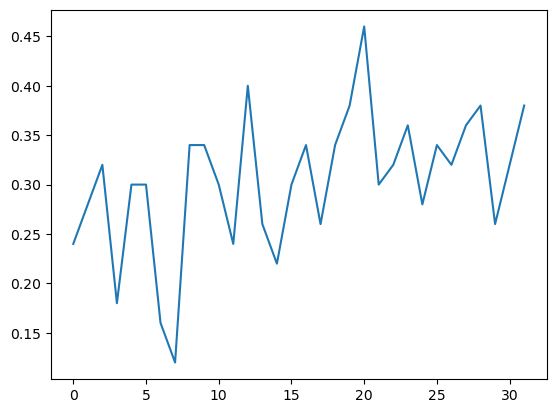

In [21]:
plt.plot(sampler.acceptance_fraction)

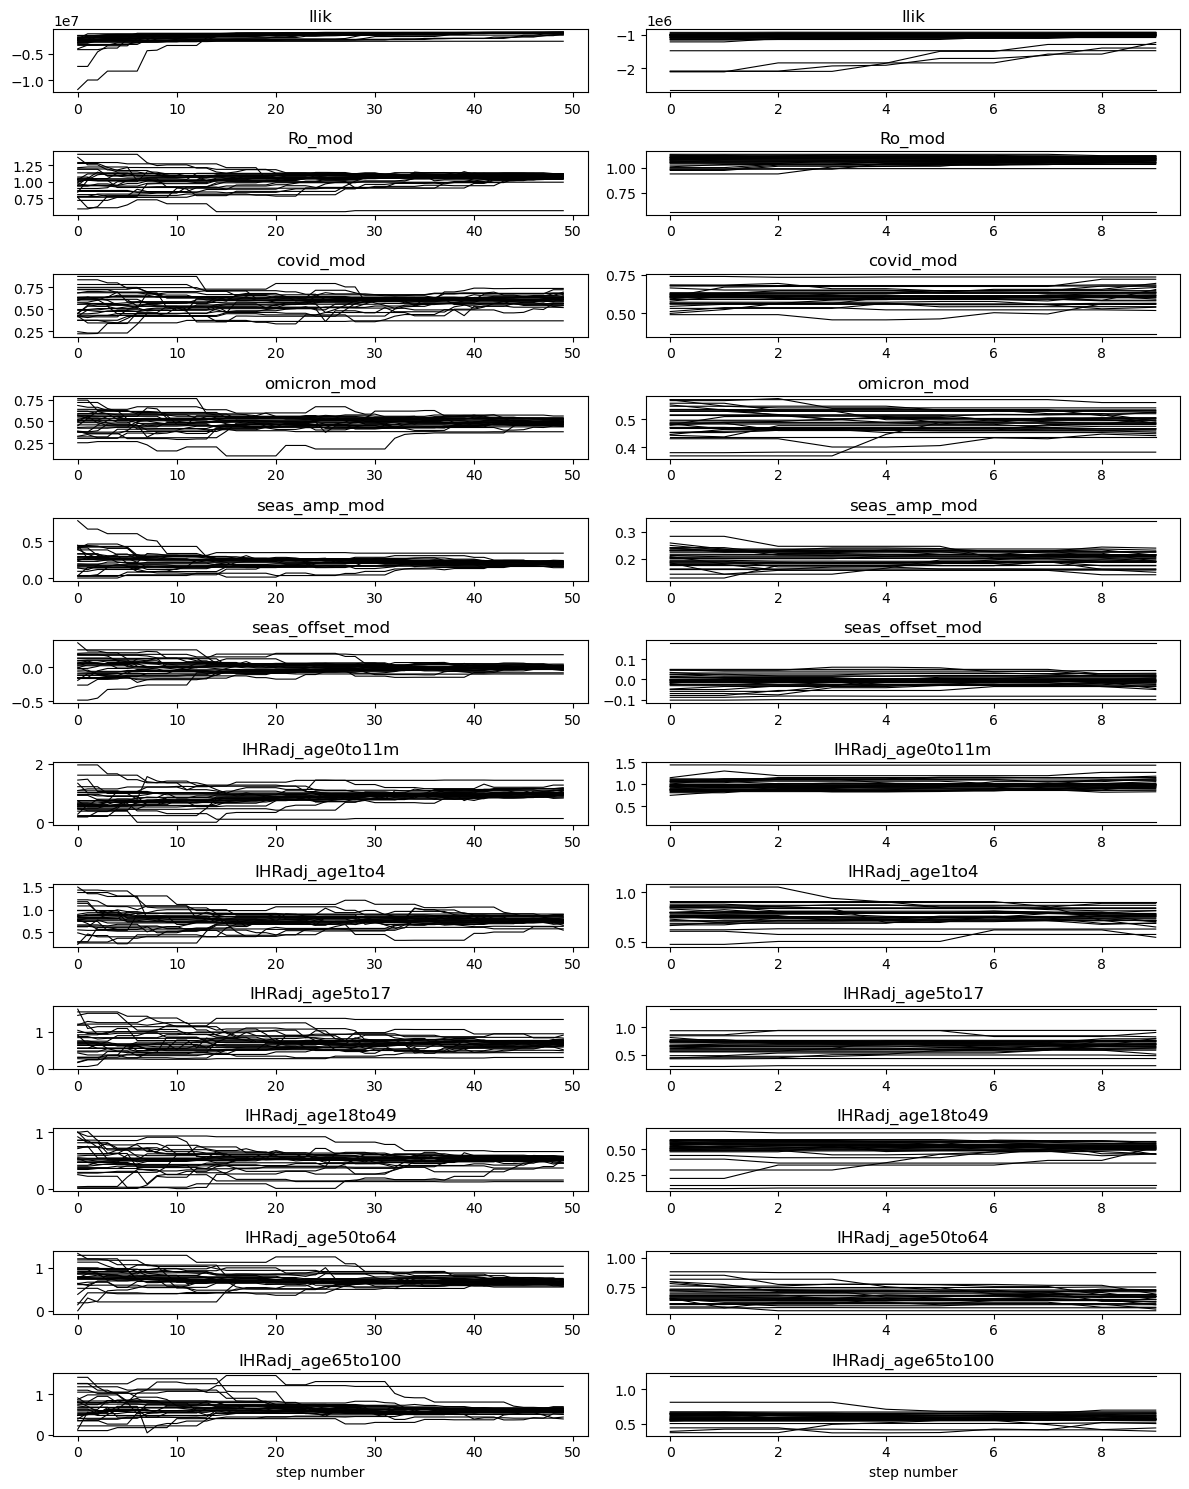

In [32]:
fig, axes = plt.subplots(ndim+1,2, figsize=(12, 15))
samples = sampler.get_chain()
labels = fitted_params["pname"]


def plot_chain(frompt,axes):
    ax = axes[0]
    ax.plot(sampler.get_log_prob()[frompt:], "k", alpha=1, lw=.8)
    ax.set_title("llik")
    #ax.set_xlim(0, len(samples))

    for i in range(ndim):
        ax = axes[i+1]
        ax.plot(samples[frompt:, :, i], "black", alpha=1, lw=.8,)
        #ax.set_xlim(0, len(samples))
        ax.set_title(labels[i])
        #ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

plot_chain(0,axes[:,0])
plot_chain(40,axes[:,1])
fig.tight_layout()

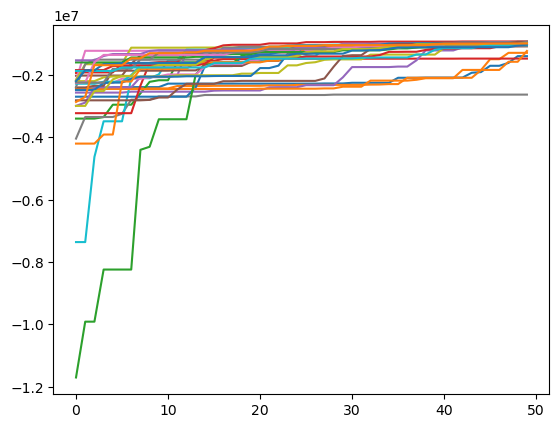

In [23]:
plt.plot(sampler.get_log_prob());


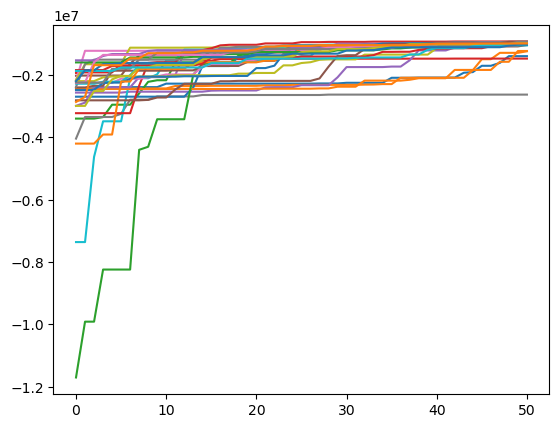

In [35]:
plt.plot(sampler.get_log_prob());

In [24]:
np.mean(sampler.get_log_prob()[-1,:])

-1091732.3620047523

In [36]:
np.mean(sampler.get_log_prob()[-1,:])

-1085804.2897442277

In [25]:
samples.shape

(50, 32, 11)

In [26]:
def input_proposal(proposal, snpi_df_ref, hnpi_df_ref, fitted_params, ndim):
    snpi_df_mod = snpi_df_ref.copy(deep=True)
    hnpi_df_mod = hnpi_df_ref.copy(deep=True)

    for i in range(ndim):
        if fitted_params["ptype"][i] == "snpi":
            snpi_df_mod.loc[snpi_df_mod["modifier_name"] == fitted_params["pname"][i],"value"] = proposal[i]
        elif fitted_params["ptype"][i] == "hnpi":
            hnpi_df_mod.loc[hnpi_df_mod["modifier_name"] == fitted_params["pname"][i],"value"] = proposal[i]

    return snpi_df_mod, hnpi_df_mod


In [27]:
samples.shape

(50, 32, 11)

In [28]:
#import concurrent.futures
#
def evaluate(proposals, k):
    proposal = proposals[k]
    snpi_df_mod, hnpi_df_mod = input_proposal(proposal, snpi_df_ref, hnpi_df_ref, fitted_params, ndim)

    outcomes_df = run_simulation(snpi_df_mod, 
                                hnpi_df_mod,
                                modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters)
    return outcomes_df
#
#with concurrent.futures.ThreadPoolExecutor(max_workers=nwalkers) as executor:
#    # Map the function to the list of k values in parallel
#    results = list(executor.map(lambda k_val: evaluate(samples[-1,:,:], k_val), np.arange(nwalkers)))
#

results = []
for k in range(nwalkers):
    results.append(evaluate(samples[-1,:,:], k))

INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
3653it [00:11, 320.62it/s]
INFO:root:[SEIR.NPI] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
3653it [00:12, 295.60it/s]
INFO:root:[SEIR.NPI] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
3653it [00:11, 310.38it/s]
INFO:root:[SEIR.NPI] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
3653it [00:11, 309.25it/s]
INFO:root:[SEIR.NPI] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:Integrating with method rk4.jit
3653it [00:11, 307.26it/s]
INFO:root:[SEIR.NPI] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
3653it [00:11, 310.92it/s]
INFO:root:[SEIR.NPI] completed in 

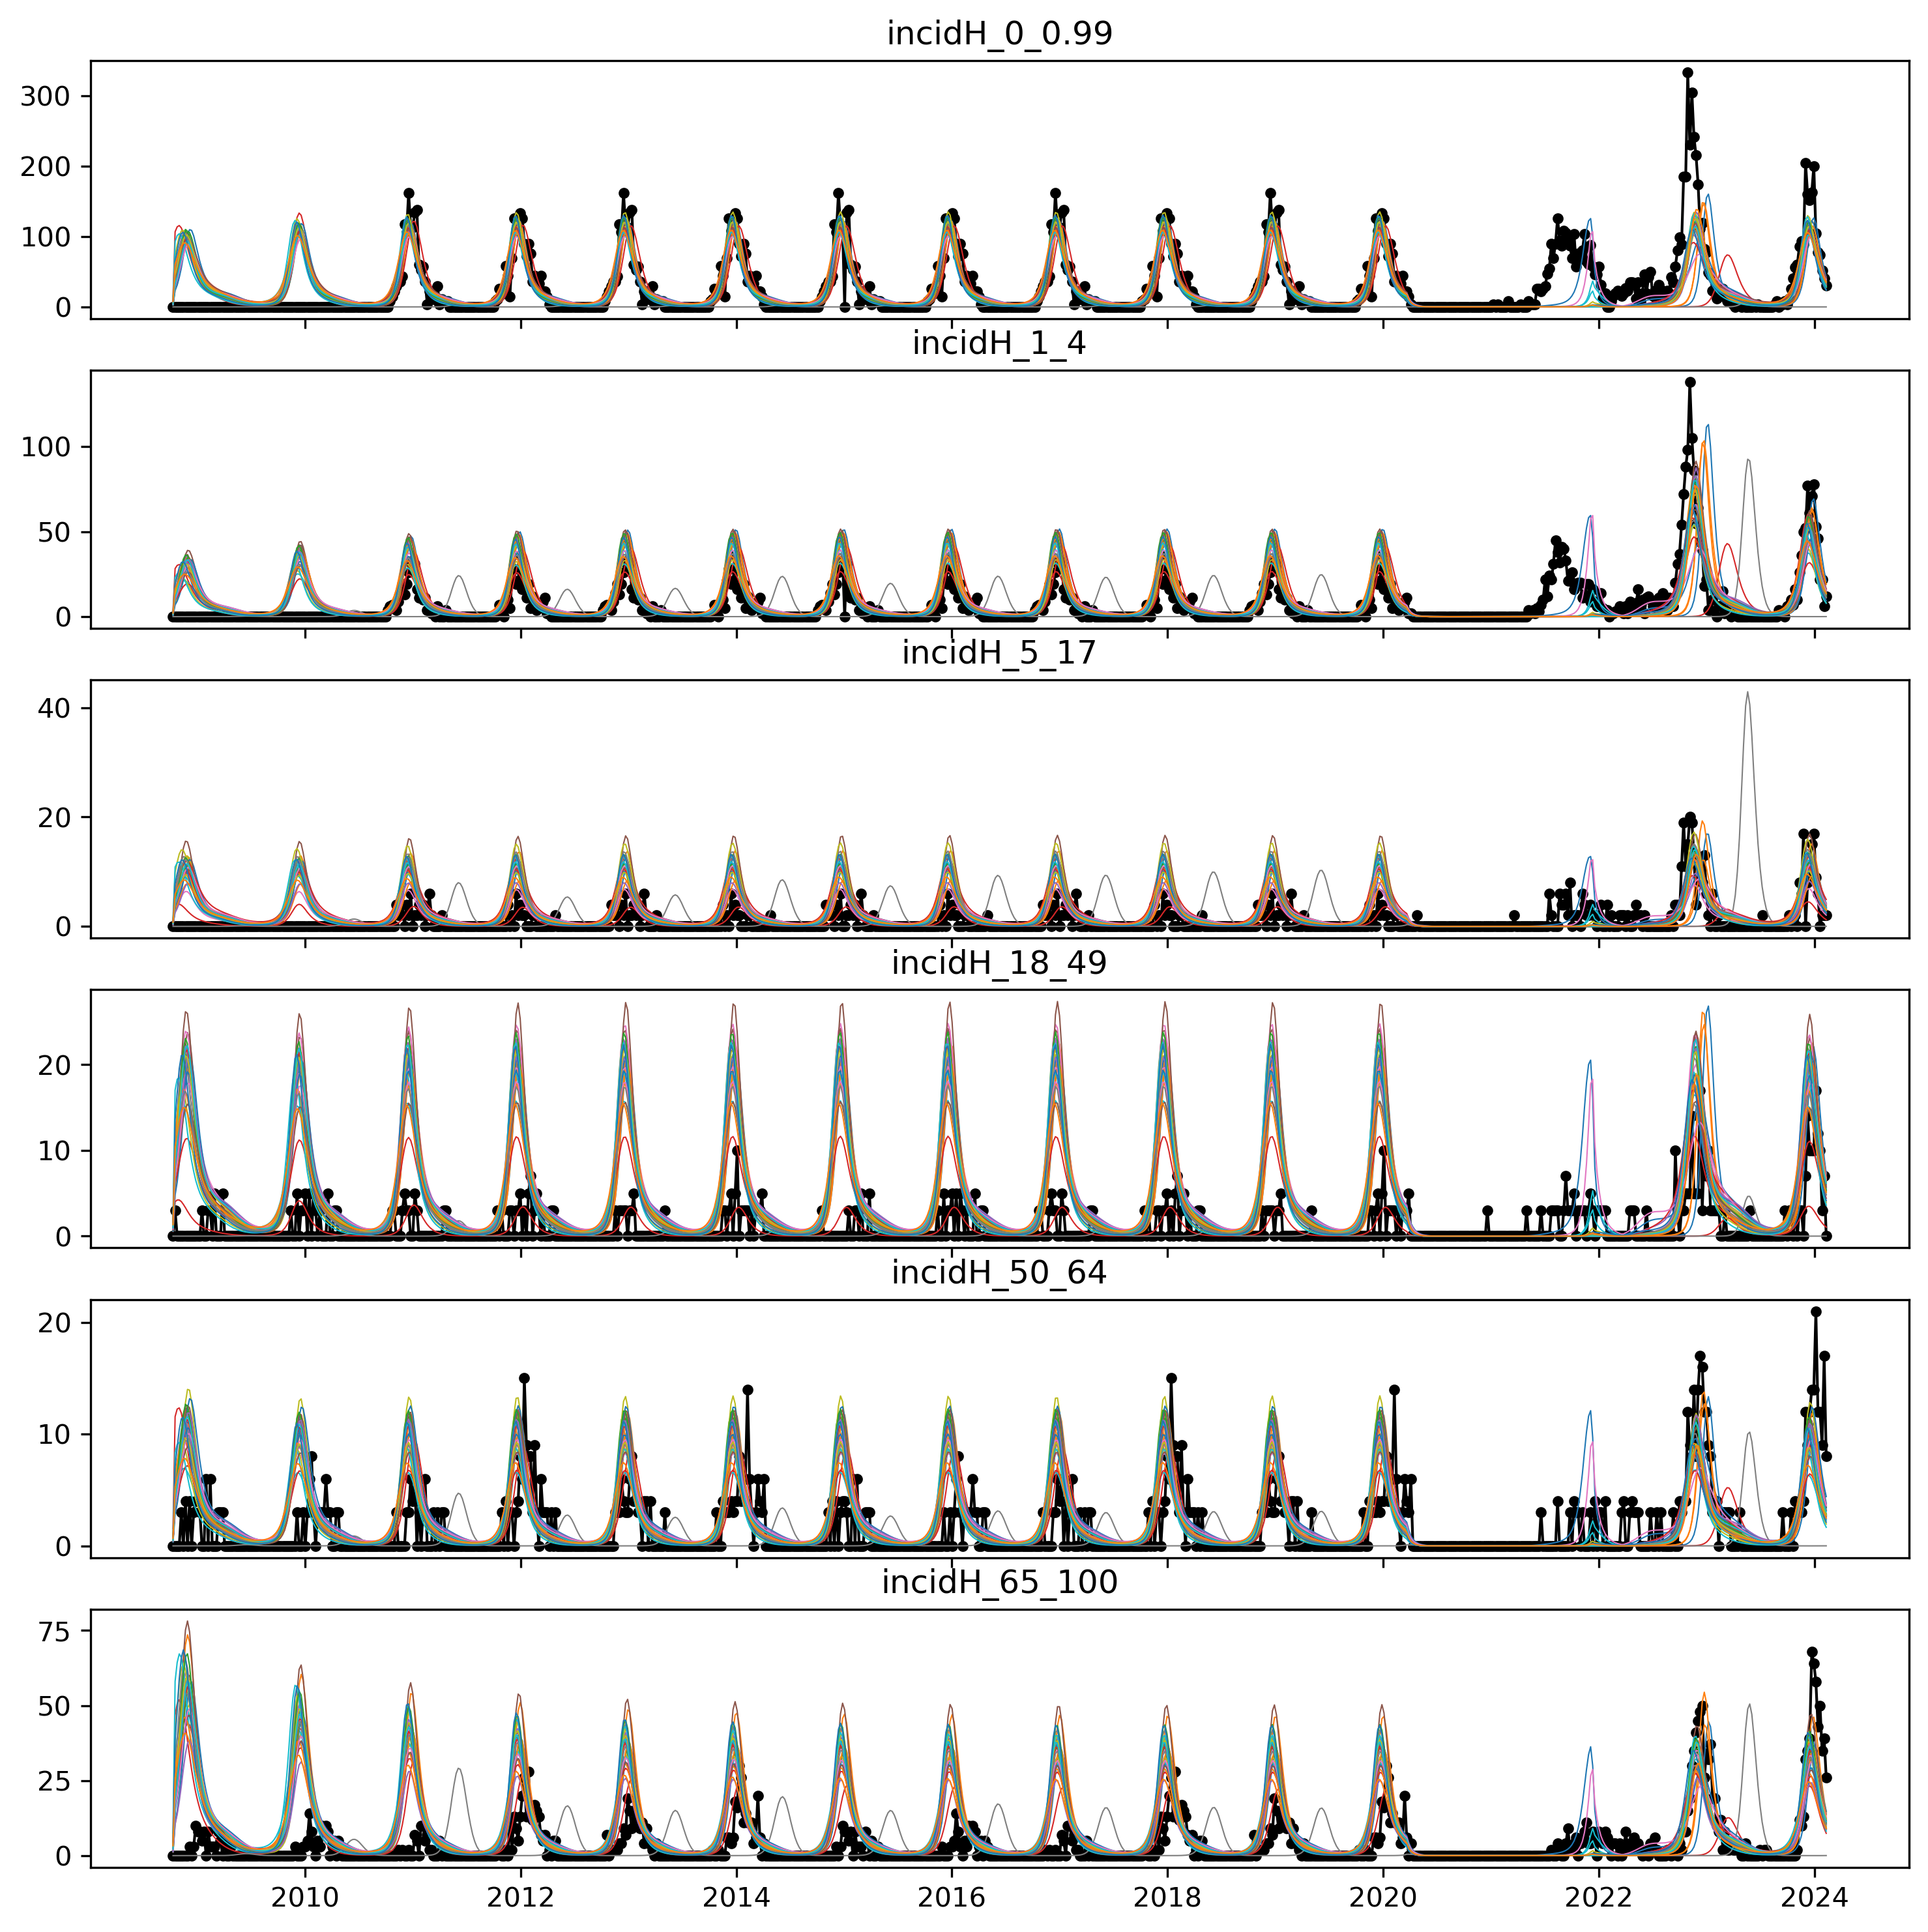

In [29]:
fig, axes = plt.subplots(len(statistics), figsize=(12, 12), sharex=True, dpi=300)
for subpop in modinf.subpop_struct.subpop_names:
        gt_s = gt[gt["subpop"]==subpop].sort_index()
        first_date = max(gt_s.index.min(),results[0].index.min())
        last_date = min(gt_s.index.max(), results[0].index.max())
        gt_s = gt_s.loc[first_date:last_date].drop(["subpop"],axis=1).resample("W-SAT").sum()
        
        for i, (key, value) in enumerate(statistics.items()):
                ax = axes.flat[i]
                ax.plot(gt_s[value], color='k', marker='.', lw=1)
                for model_df in results:
                        model_df_s = model_df[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[first_date:last_date].resample("W-SAT").sum() # todo sub subpop here
                        ax.plot(model_df_s[key],  lw=.5)
                #if True:
                #        init_df_s = outcomes_df_ref[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                ax.set_title(value)

In [33]:
emcee.__version__

'3.1.4'

In [30]:
import corner

In [31]:
#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=100, thin=2,flat=True) #discard=100, thin=15, 
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels, #truths=[m_true, b_true, np.log(f_true)]
);

(0, 11)


/Users/chadi/anaconda3/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1) than draws (0). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


AssertionError: I don't believe that you want more dimensions than samples!